# Evaluating Model Performance through a User-centric Explainable Framework for Probabilistic Load Forecasting Models
## Overview
This notebook reproduces and evaluates a user-centric Explainable AI (XAI) framework for probabilistic load forecasting models using real-world energy demand data.

TODO: this part will be updated later (especially want to test on different training models).

The model estimates interval-based forecasts using Gradient Boosting Regressors(GBR) and explains predictions using both global (PFI) and local (SHAP) techniques — addressing the needs of both AI developers and non-AI end-users such as system operators and market participants.

## Dataset
The dataset used in this implementation is sourced from [Kaggle](https://www.kaggle.com/saurabhshahane/electricity-load-forecasting), which provides hourly national electricity demand for Panama, along with relevant weather data, holiday indicators, and datetime metadata from 2015 to 2020.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/electricity-load-forecasting")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\danyi\.cache\kagglehub\datasets\saurabhshahane\electricity-load-forecasting\versions\1


## Load and inspect the dataset
After successfully downloading the dataset, we load the main CSV file (`continuous dataset.csv`) which contains continuous hourly measurements of national electricity demand in Panama, as well as relevant weather and calendar features.
We display the first few rows to verify that the dataset has been loaded correctly and to get an initial understanding of the structure.

In [3]:
import pandas as pd

df = pd.read_csv(path + "/continuous dataset.csv")
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


## Convert to Datetime Format
The dataset contains a `datetime` column in string format. To enable time-based filtering, feature extraction, and chronological modeling, we need to convert it into pandas `datetime` format.

This step ensures that we can extract relevant time-based features such as **hour, month, day of week**, etc., and perform time series operations reliably.

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

## Rename columns and create lag features

To align with the variable notation used in the original researh paper, we rename the dataset's columns to more interpretable forms - particularly weather variables from Tocumen, Santiago and David.

We also generate **lagged features** for electricity demand:
- `load_t`: current hour load
- `load_t-1`: one hour ago
- `load_t-2`: two hours ago
- `load_t+1`: the value to be predicted (target for supervised learning)

These lags are crucial for capturing temporal dependencies in the load forecasting problem.

In [5]:
df.rename(columns={
    'nat_demand': 'load',
    'T2M_toc': 'T_c1', 'QV2M_toc': 'H_c1', 'TQL_toc': 'γ_c1', 'W2M_toc': 'W_c1',
    'T2M_san': 'T_c2', 'QV2M_san': 'H_c2', 'TQL_san': 'γ_c2', 'W2M_san': 'W_c2',
    'T2M_dav': 'T_c3', 'QV2M_dav': 'H_c3', 'TQL_dav': 'γ_c3', 'W2M_dav': 'W_c3',
    'holiday': 'holiday'
}, inplace=True)

# Eelmiste tundide koormused
df['load_t'] = df['load']
df['load_t-1'] = df['load'].shift(1)
df['load_t-2'] = df['load'].shift(2)
df['load_t+1'] = df['load'].shift(-1)

print(df.columns)

Index(['datetime', 'load', 'T_c1', 'H_c1', 'γ_c1', 'W_c1', 'T_c2', 'H_c2',
       'γ_c2', 'W_c2', 'T_c3', 'H_c3', 'γ_c3', 'W_c3', 'Holiday_ID', 'holiday',
       'school', 'load_t', 'load_t-1', 'load_t-2', 'load_t+1'],
      dtype='object')


## Train-test split
Based on original paper's methodology, we split the dataset into three parts:
- **Training set:** 2015–2017
- **Testing set:** 2018–2019
- **Validation set:** 2020 (to assess generalization on unseen data)

This temporal split ensures that the model learns from past data and is evaluated on future, unseen data — which is essential for time series forecasting.

We also define the `features` used for training, including:
- Time-based variables (`month`, `hour`)
- Lagged load values (`load_t`, `load_t-1`, `load_t-2`)
- Weather variables from three cities
- Holiday indicator

We then extract the target variable: **`load_t+1`**, representing the demand one hour ahead.

In [6]:
features = [
    'month', 'hour',
    'load_t', 'load_t-1', 'load_t-2',
    'T_c1', 'H_c1', 'γ_c1', 'W_c1',
    'T_c2', 'H_c2', 'γ_c2', 'W_c2',
    'T_c3', 'H_c3', 'γ_c3', 'W_c3',
    'holiday'
]

df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

# Filtreerime andmed kolme perioodi alusel
train_df = df[df['datetime'].dt.year <= 2017].dropna()
test_df  = df[(df['datetime'].dt.year >= 2018) & (df['datetime'].dt.year <= 2019)].dropna()
val_df   = df[df['datetime'].dt.year == 2020].dropna()

# Sisendid ja sihtväärtused (soovime ennustada, mis hakkab toimuma ajahetkel t+1)
X_train, y_train = train_df[features], train_df['load_t+1']
X_test, y_test = test_df[features], test_df['load_t+1']
X_val, y_val = val_df[features], val_df['load_t+1']


# This part will cover different training models and later will be validated which one was performing better and which one less.







plan to implement:
1. LinearRegression - DONE
2. GradientBoostingRegressor - DONE
3. XGBoost, LightGBM - DONE
4. RandomForestRegressor - DONE
5. ARIMA
6. LSTM

### Validate Models
For validation there are different metrics
1. The Mean Absolute Error (MAE) is a common metric used to evaluate the performance of regression models. It measures the average magnitude of the errors between predicted values and actual values, without considering their direction.


$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$
Where:

- $n$ is the number of observations
- $y_i$ is the actual value
- $\hat{y}_i$ is the predicted value
- $|\cdot|$ denotes the absolute value
<br></br>
2. The Mean Squared Error (MSE) is a common metric used to evaluate the performance of regression models. It measures the average of the squares of the differences between predicted values and actual values.
    Because the errors are squared, larger errors have a greater impact on the final result. This makes MSE more sensitive to outliers compared to MAE.
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$
Where:

- $n$ is the number of observations
- $y_i$ is the actual value
- $\hat{y}_i$ is the predicted value
- The square $(\cdot)^2$ penalizes larger errors more heavily

<div style="display: flex; justify-content: center;">
    <img src="images/mae.png" alt="MAE Formula" width="400" height="400" style="margin-right: 10px;"/>
    <img src="images/mse.png" alt="MSE Formula" width="400" height="400"/>
</div>



# 1. Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

Linear Regression (17.01–23.01)
MAE  = 36.88
MSE  = 6387.53
RMSE = 79.92
MAPE = 7.99
R2   = 0.88


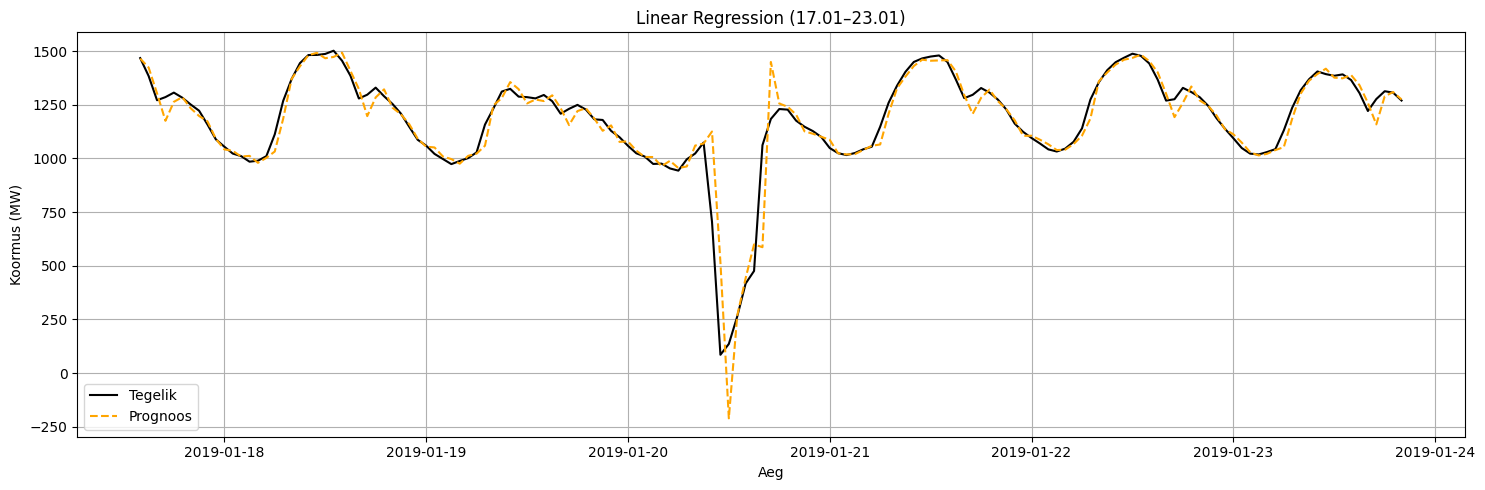

Linear Regression – esimesed 200 tundi
MAE  = 26.57
MSE  = 1290.28
RMSE = 35.92
MAPE = 2.42
R2   = 0.96


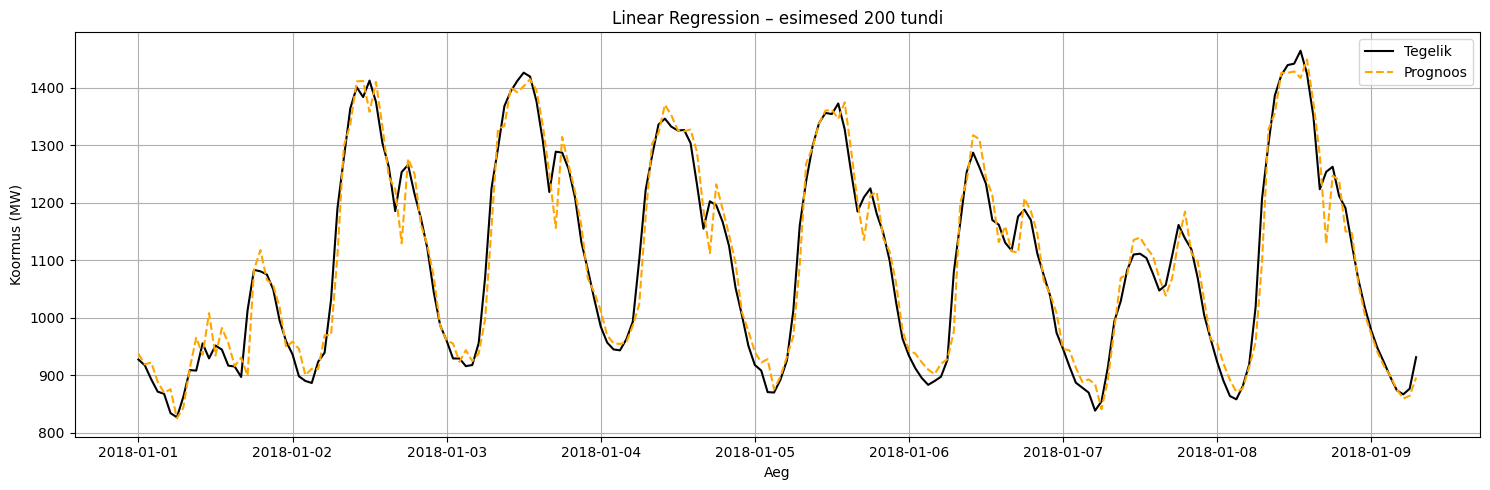

Linear Regression – kõik testandmed
MAE  = 28.85
MSE  = 1707.22
RMSE = 41.32
MAPE = 2.39
R2   = 0.95


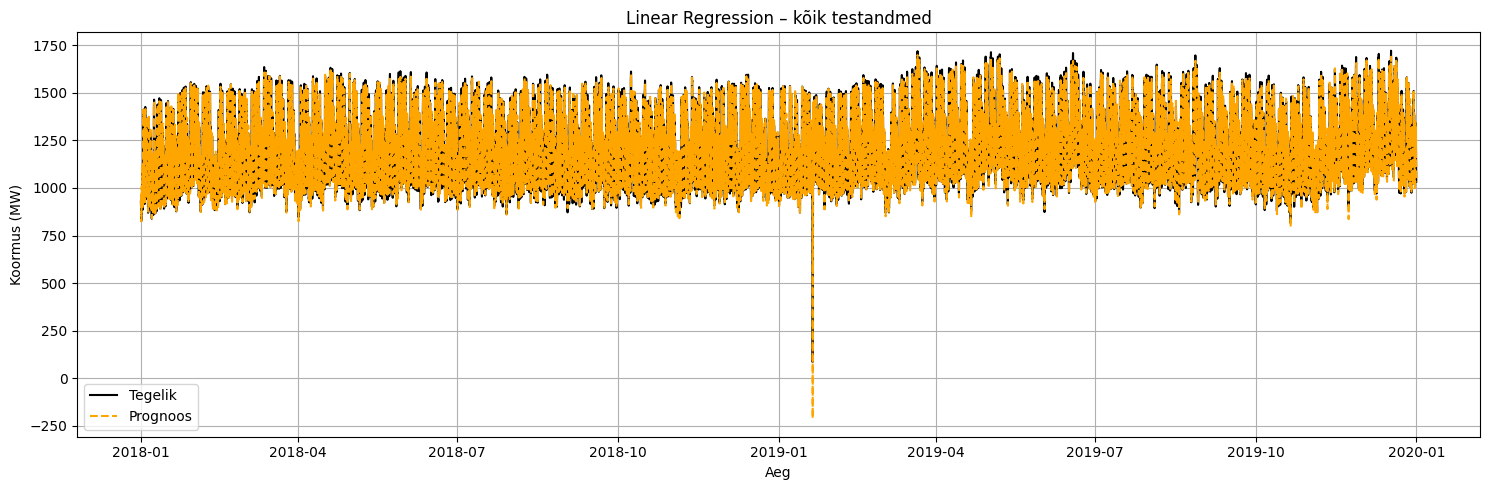

In [9]:
from helper import *
# VALIDATE LINEAR REGRESSION MODEL
evaluate_all_cases(y_test, y_pred_lin, test_df['datetime'], "Linear Regression")

# 2. XGBoost

In [10]:
from xgboost import XGBRegressor
xgbb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
xgbb.fit(X_train, y_train)
y_pred_xgb = xgbb.predict(X_test)

XGBoost (17.01–23.01)
MAE  = 42.84
MSE  = 17494.44
RMSE = 132.27
MAPE = 15.53
R2   = 0.67


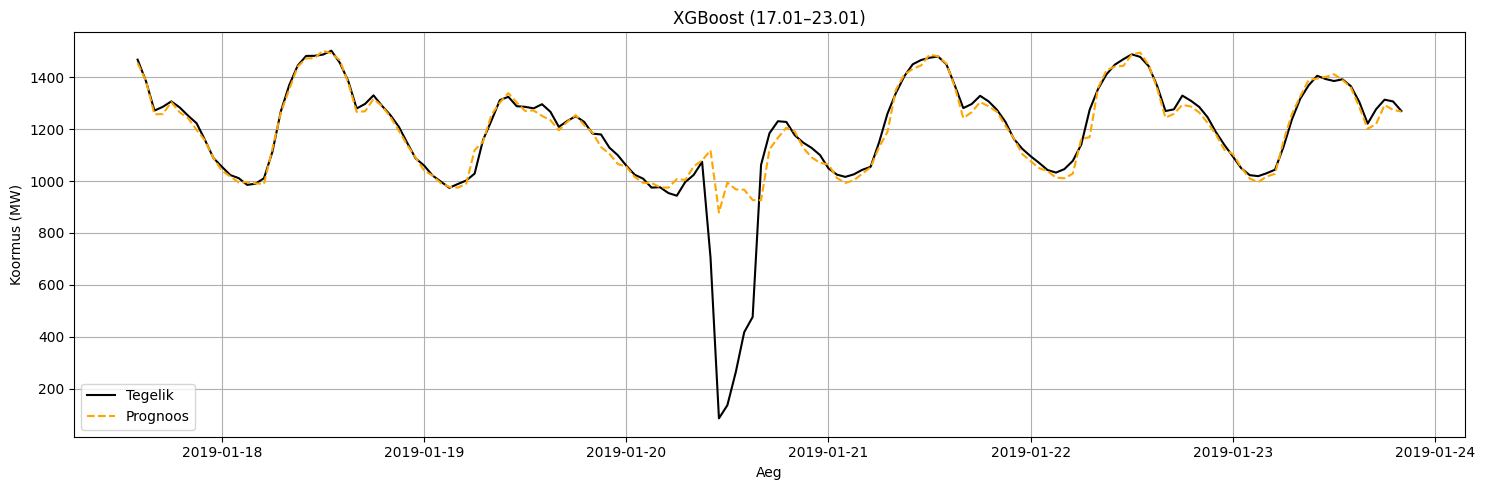

XGBoost – esimesed 200 tundi
MAE  = 14.12
MSE  = 374.46
RMSE = 19.35
MAPE = 1.29
R2   = 0.99


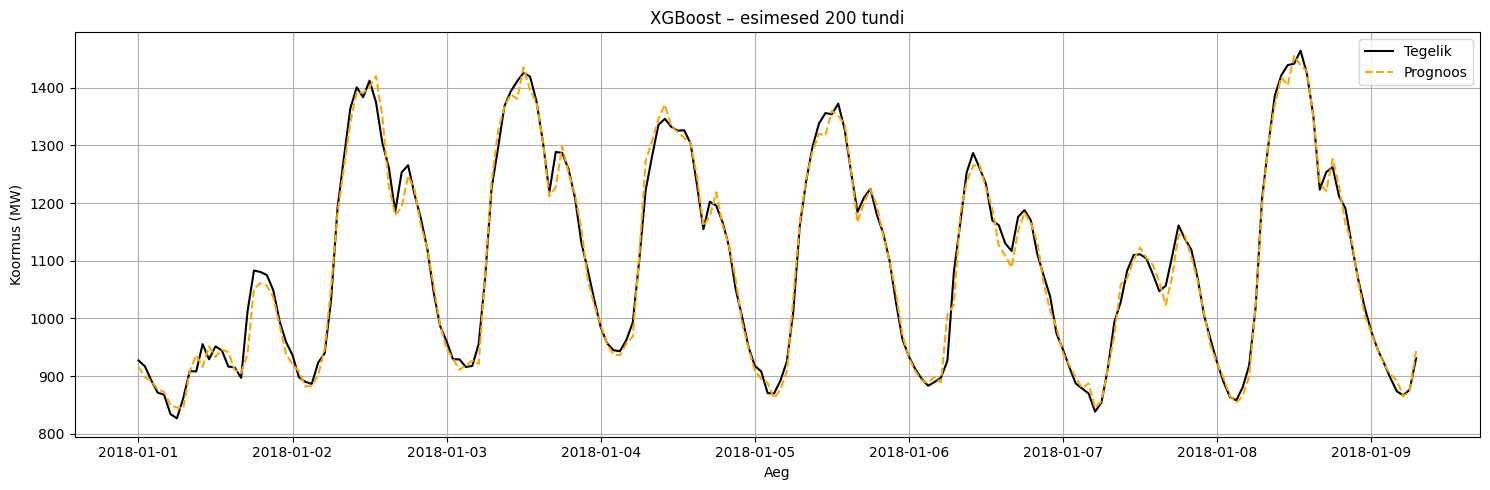

XGBoost – kõik testandmed
MAE  = 17.89
MSE  = 821.53
RMSE = 28.66
MAPE = 1.54
R2   = 0.98


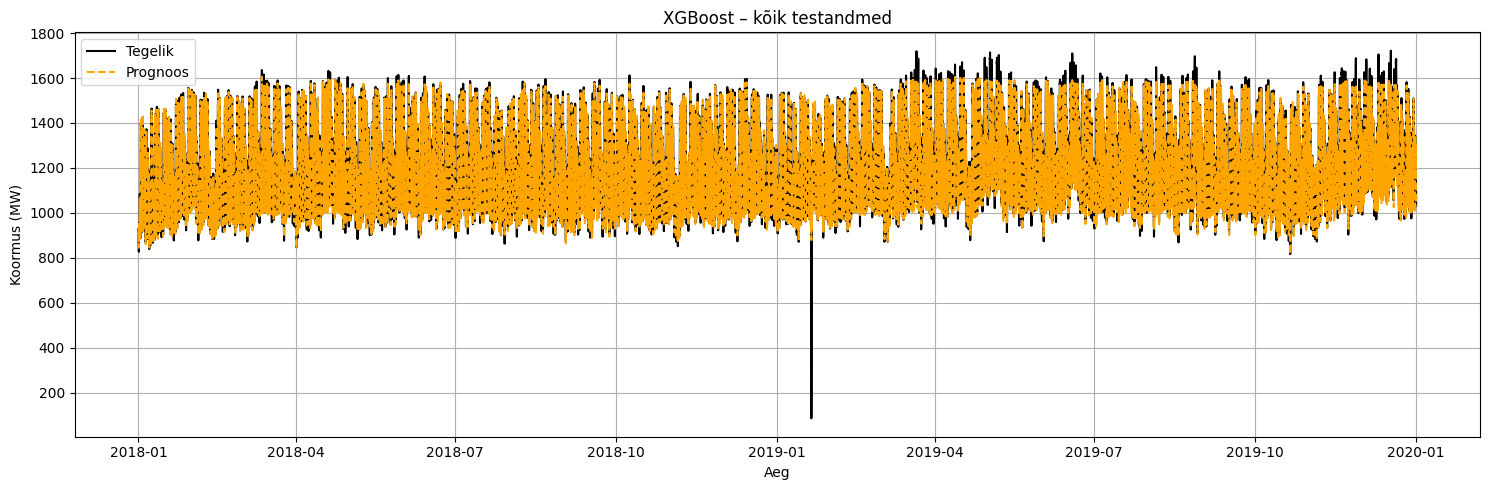

In [11]:
evaluate_all_cases(y_test, y_pred_xgb, test_df['datetime'], "XGBoost")

# 3. Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

RandomForest (17.01–23.01)
MAE  = 44.29
MSE  = 17326.47
RMSE = 131.63
MAPE = 15.59
R2   = 0.68


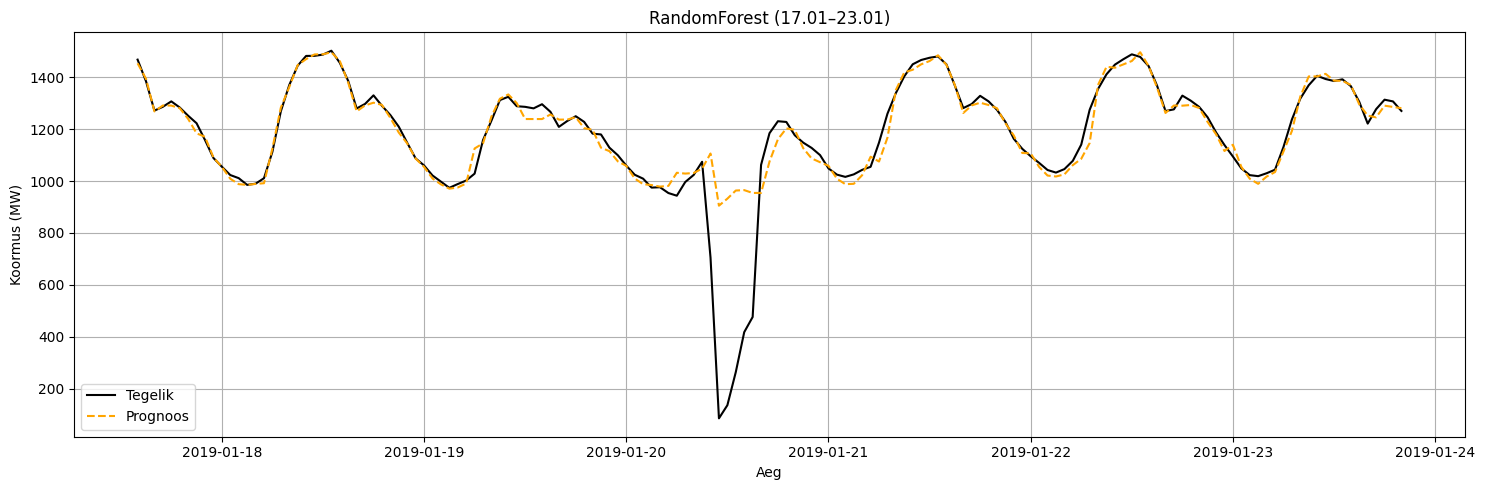

RandomForest – esimesed 200 tundi
MAE  = 19.03
MSE  = 682.81
RMSE = 26.13
MAPE = 1.78
R2   = 0.98


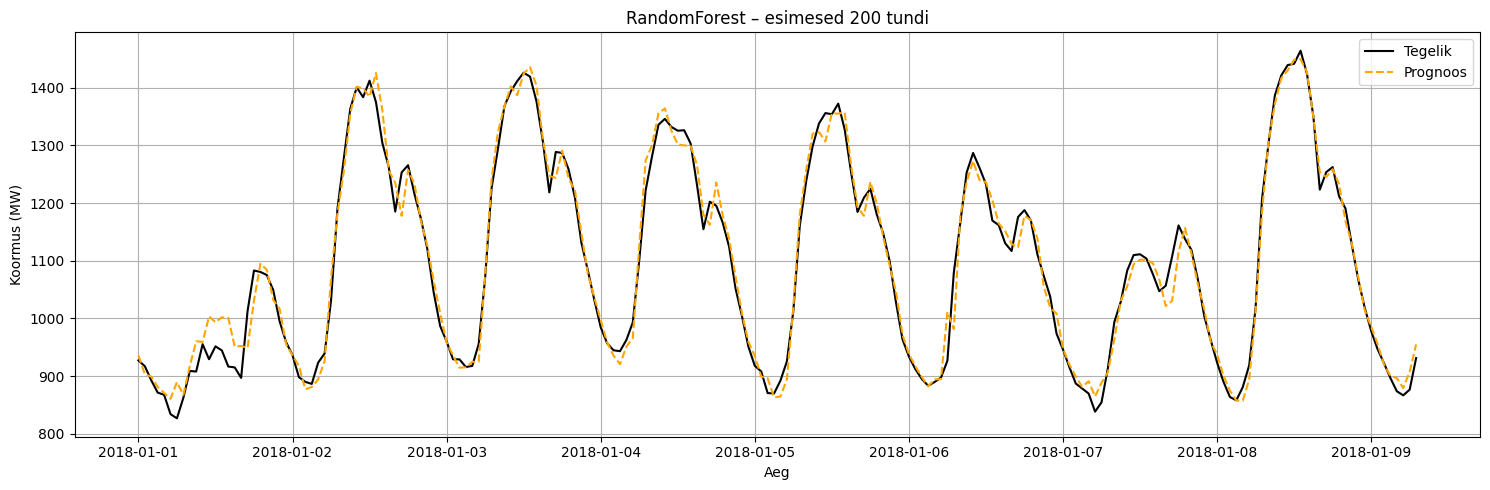

RandomForest – kõik testandmed
MAE  = 22.21
MSE  = 1140.20
RMSE = 33.77
MAPE = 1.91
R2   = 0.97


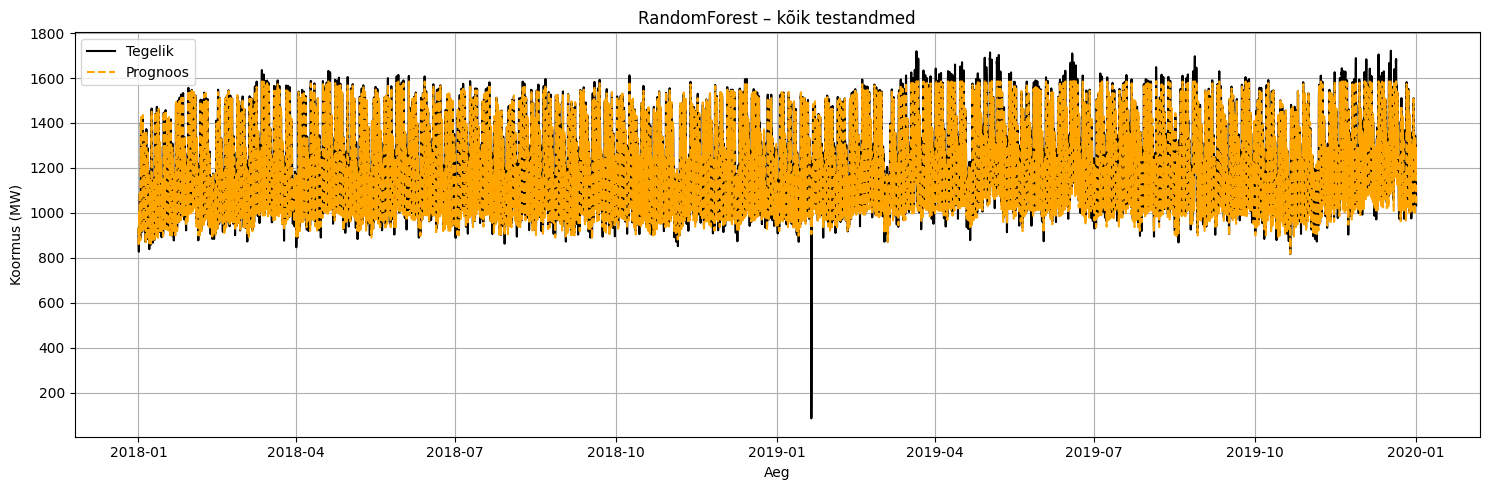

In [13]:
evaluate_all_cases(y_test, y_pred_rfr, test_df['datetime'], "RandomForest")

## 4. LSTM

In [ ]:
print("hello")
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense
# convert an array of values into a dataset matrix

# def create_sequences(X, y, seq_len):
#     Xs, ys = [], []
#     for i in range(len(X) - seq_len):
#         Xs.append(X[i:i+seq_len])
#         ys.append(y[i+seq_len])
#     return np.array(Xs), np.array(ys)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# sequence_length = 24  # 24 tunni aken
# X_lstm_train, y_lstm_train = create_sequences(X_train_scaled, y_train.values, sequence_length)
# X_lstm_test, y_lstm_test = create_sequences(X_test_scaled, y_test.values, sequence_length)

# lstm = Sequential([
#     LSTM(64, activation='relu', input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])),
#     Dense(1)
# ])
# lstm.fit(X_lstm_train, y_lstm_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
# y_pred_lstm = lstm.predict(X_lstm_test).flatten()
#
# datetime_aligned = test_df['datetime'].iloc[sequence_length:].reset_index(drop=True)


In [ ]:
evaluate_all_cases(
    y_test=y_lstm_test,
    y_pred=y_pred_lstm,
    time_index=datetime_aligned,
    model_name="LSTM"
)


# 3. GBR model training
GBR:
Pros
- captures complex nonlinear patterns
- handles interactions between features well
- can use external variables (weather, promotions, etc)

Neg
- Does not know about time unless you tell it
- It treats time points as just another feature, unless you add time lags, add rolling averages, trends, seasonality indicators, use date/time features

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# Lower model: 5% quantile
gbr_lower = GradientBoostingRegressor(loss='quantile', alpha=0.05, n_estimators=100)
gbr_lower.fit(X_train, y_train)

# Upper model: 95% quantile
gbr_upper = GradientBoostingRegressor(loss='quantile', alpha=0.95, n_estimators=100)
gbr_upper.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, loss='quantile')

TODO: Comparance- different models. For example linear regression, logaritmic regression, gdxboost

##


# Ennustame testandmetel

In [14]:
pred_lower = gbr_lower.predict(X_test)
pred_upper = gbr_upper.predict(X_test)

true_load = y_test

# Visualiseerime


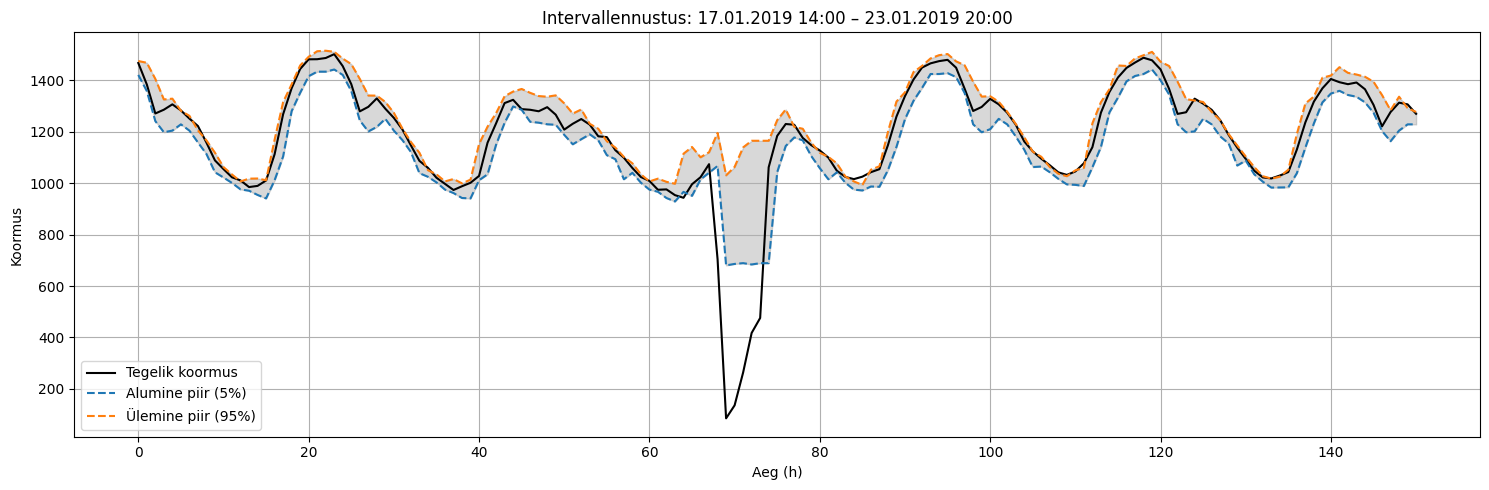

In [15]:
start_date = "2019-01-17 14:00"
end_date = "2019-01-23 20:00"

# Filtreerime test_df vastavalt ajavahemikule
subset = test_df[(test_df['datetime'] >= start_date) & (test_df['datetime'] <= end_date)]

# X ja y selle vahemiku jaoks
X_test_sub = subset[features]
y_true_sub = subset['load_t+1']

# Ennustame
pred_lower_sub = gbr_lower.predict(X_test_sub)
pred_upper_sub = gbr_upper.predict(X_test_sub)

# Visualiseeri
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_true_sub.values, label='Tegelik koormus', color='black')
plt.plot(pred_lower_sub, label='Alumine piir (5%)', linestyle='--')
plt.plot(pred_upper_sub, label='Ülemine piir (95%)', linestyle='--')
plt.fill_between(range(len(pred_lower_sub)), pred_lower_sub, pred_upper_sub, color='gray', alpha=0.3)
plt.title('Intervallennustus: 17.01.2019 14:00 – 23.01.2019 20:00')
plt.xlabel('Aeg (h)')
plt.ylabel('Koormus')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# import matplotlib.pyplot as plt
#
# # Valime vahemiku (nt 200 esimest rida)
# n = 200
#
# plt.figure(figsize=(15, 5))
# plt.plot(true_load.iloc[:n].values, label='Tegelik koormus', color='black')
# plt.plot(pred_lower[:n], label='Alumine piir (5%)', linestyle='--')
# plt.plot(pred_upper[:n], label='Ülemine piir (95%)', linestyle='--')
# plt.fill_between(range(n), pred_lower[:n], pred_upper[:n], color='gray', alpha=0.2)
# plt.title('GBR-põhine intervallennustus')
# plt.xlabel('Aeg (tunnid)')
# plt.ylabel('Koormus')
# plt.legend()
# plt.grid(True)
# plt.show()



# PFI
- PFI hindab üldiselt, kui palju iga tunnus mõjutab mudeli täpsust. See ei anna infot üksikute ennustuste kohta, vaid ütleb ainult, kui oluline on tunnus mudeli jaoks keskmiselt.

- Kui palju mudel “läheb segadusse”, kui me mingi veeru (feature) väärtused sassi ajame (permutatsioon).


In [16]:
from sklearn.inspection import permutation_importance
import pandas as pd

# PFI alumise mudeli jaoks
pfi_lower = permutation_importance(
    gbr_lower, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
)

# PFI ülemise mudeli jaoks
pfi_upper = permutation_importance(
    gbr_upper, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
)

# Koondame tulemused DataFrame’i
pfi_df = pd.DataFrame({
    'Feature': features,
    'PFI_Lower': pfi_lower.importances_mean,
    'PFI_Upper': pfi_upper.importances_mean
}).sort_values(by='PFI_Upper', ascending=False)

pfi_df.reset_index(drop=True, inplace=True)
pfi_df


,Feature,PFI_Lower,PFI_Upper
0,load_t,58629.696216,57699.435565
1,hour,2612.323383,6428.699309
2,load_t-2,497.041617,835.162539
3,T_c1,177.581170,42.755387
4,γ_c1,-10.654292,8.233984
5,T_c3,8.861318,4.784451
6,H_c2,-7.059078,3.309435
7,H_c1,0.341600,1.425565
8,γ_c3,0.451131,1.250014
9,H_c3,0.466789,0.988817


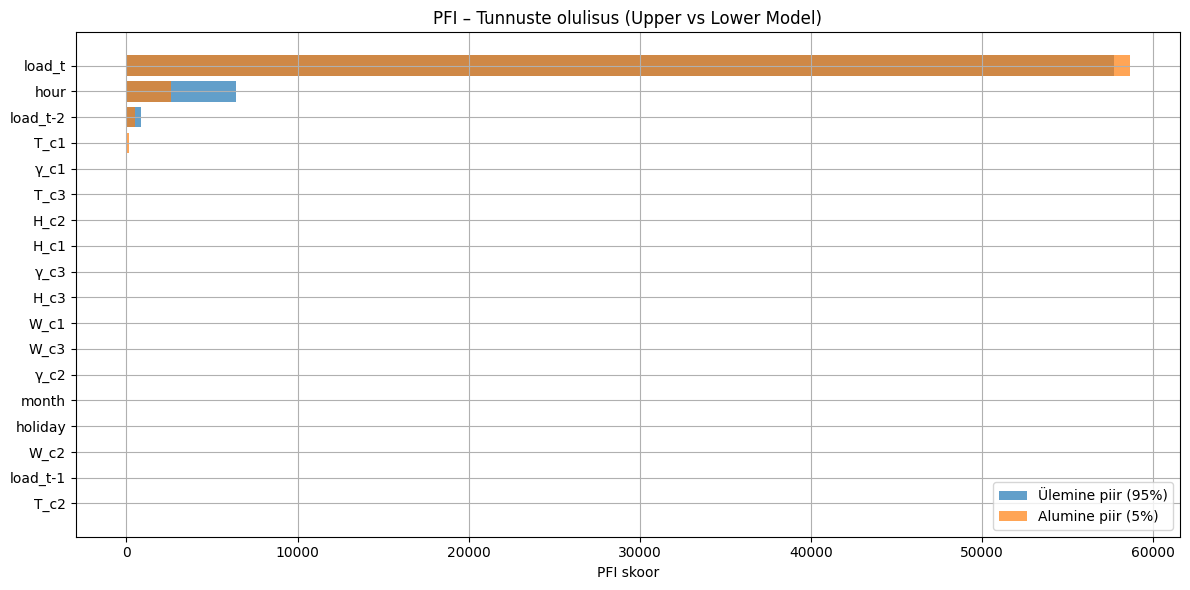

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(pfi_df['Feature'], pfi_df['PFI_Upper'], label='Ülemine piir (95%)', alpha=0.7)
plt.barh(pfi_df['Feature'], pfi_df['PFI_Lower'], label='Alumine piir (5%)', alpha=0.7)
plt.gca().invert_yaxis()
plt.title('PFI – Tunnuste olulisus (Upper vs Lower Model)')
plt.xlabel('PFI skoor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SHAP
See meetod ütleb, miks mudel tegi konkreetse ennustuse, analüüsides, kui palju iga sisendtunnus (feature) ennustust mõjutas.
See võimaldab hinnata, millised tegurid olid iga üksiku prognoosi puhul määravad.

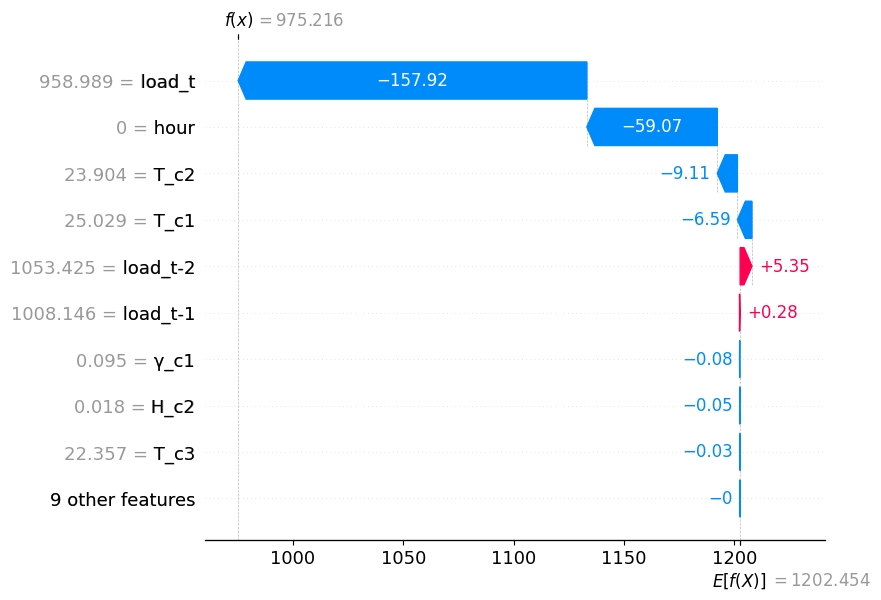

In [18]:
import shap

# Loome explaineri (Gradient Boosting puhul nt TreeExplainer)
explainer_upper = shap.Explainer(gbr_upper)
shap_values_upper = explainer_upper(X_test)

# Valime ühe konkreetse hetke (nt 0. indeks)
shap.plots.waterfall(shap_values_upper[0], max_display=10)

Mida see graafik näitab?
Mudel ennustas: f(x) = 975.216

Keskmine prognoos (E[f(X)]) oli ~1202.45 → mudel “arvas alla keskmise”

Suurimad mõjujõud:

🔵 load_t: −157.92 → väga suur langetav mõju (hetke koormus oli madal)

🔵 hour: −59.07 → ilmselt madala tarbimise aeg (öö?)

🔵 T_c2, T_c1: väiksemad negatiivsed mõjud

🔴 load_t-2: +5.35 → kergelt tõstis ennustust


SHAP võrdleb iga sisendit keskmise ennustusega:

Graafiku lõpus on E[f(x)] = 1202.454 → see on mudeli keskmine ennustus, kui ühtegi tunnust ei muudeta.

load_t = 958.989 → see oli selle hetke tegelik väärtus.

Kui see oleks olnud näiteks 1300, oleks see SHAP väärtus ilmselt positiivne.

Kuna load_t oli madalam kui mudel tavaliselt eeldab, siis:

Mudel ütles: "hetkekoormus on madal, järelikult ilmselt järgmine tund tuleb ka madalam"

Seega ennustas vähem kui keskmine, ja load_t andis negatiivse panuse

